In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
%config InlineBackend.figure_format = "retina"
%matplotlib notebook

# References
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

# Data

In [2]:
df = sns.load_dataset("tips")
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<IPython.core.display.Javascript object>


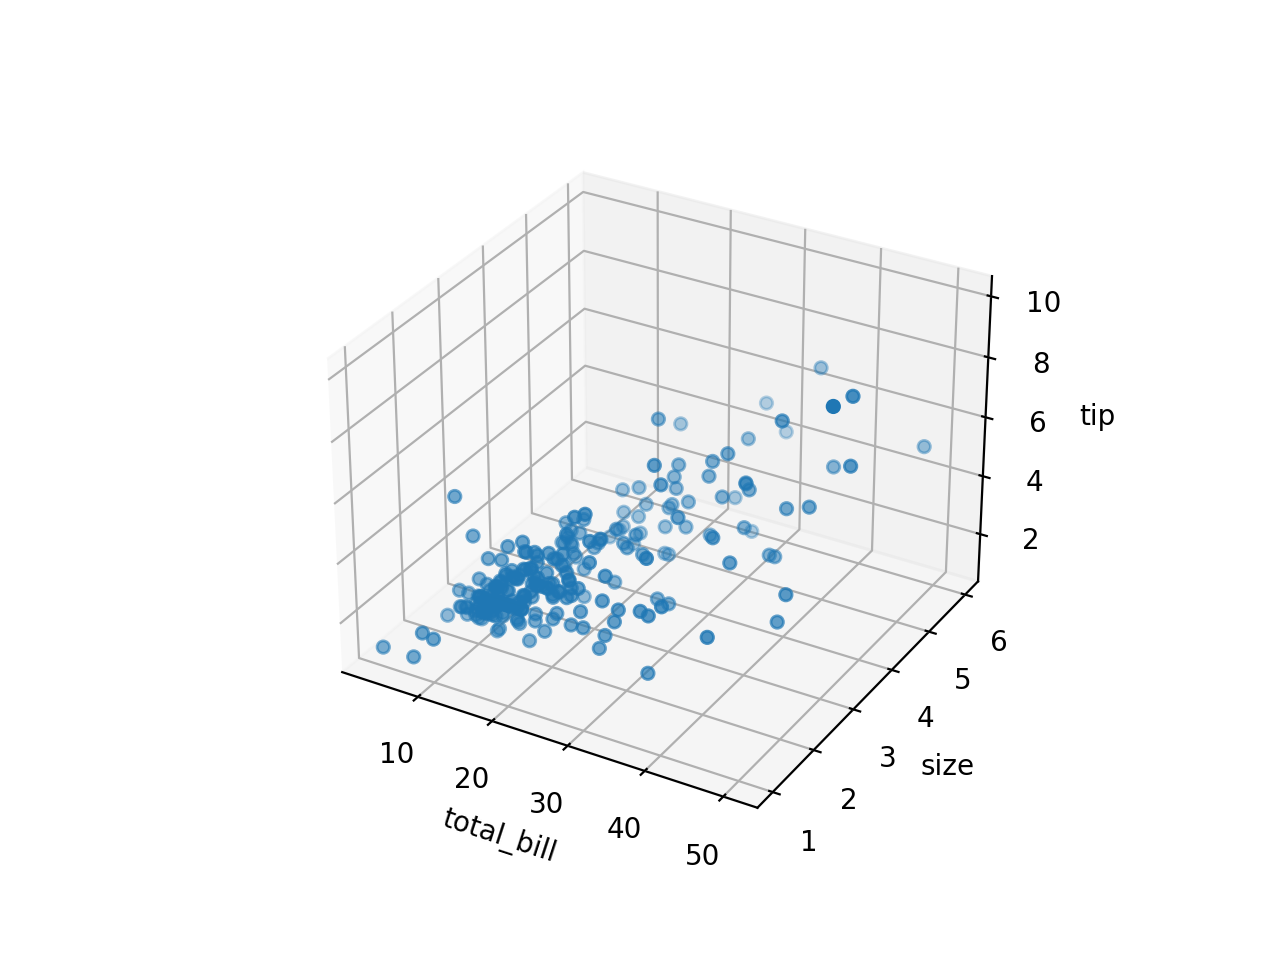

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter("total_bill", "size", "tip", data=df)
ax.set(xlabel="total_bill", ylabel="size", zlabel="tip");

# Using linear regression to make predictions

Linear regression predictor: $h(\mathbf{x}) = \mathbf{w}^T\mathbf{x}$ where $\mathbf{w}$ is the weight vector and $\mathbf{x}$ is a feature vector.

Let's use scikit-learn to fit a weight vector from the data to predict `tip` using the features `total_bill` and `size`.

In [4]:
w_star = LinearRegression(fit_intercept=False).fit(df[["total_bill", "size"]], df["tip"]).coef_
print(f"weight vector = [{w_star[0]:.2f}, {w_star[1]:.2f}]")
print("feature vector = [total_bill, size]")
print(f"tip = {w_star[0]:.2f} * total_bill + {w_star[1]:.2f} * size")

weight vector = [0.10, 0.36]
feature vector = [total_bill, size]
tip = 0.10 * total_bill + 0.36 * size


In [5]:
def plot_hyperplane():
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter("total_bill", "size", "tip", data=df)
    ax.set(xlabel="total_bill", ylabel="size", zlabel="tip")

    xx, yy = np.meshgrid(df["total_bill"].agg(["min", "max"]), df["size"].agg(["min", "max"]), indexing="xy")
    zz = w_star[0] * xx + w_star[1] * yy
    ax.plot_surface(xx, yy, zz, alpha=.5)
    return ax

<IPython.core.display.Javascript object>


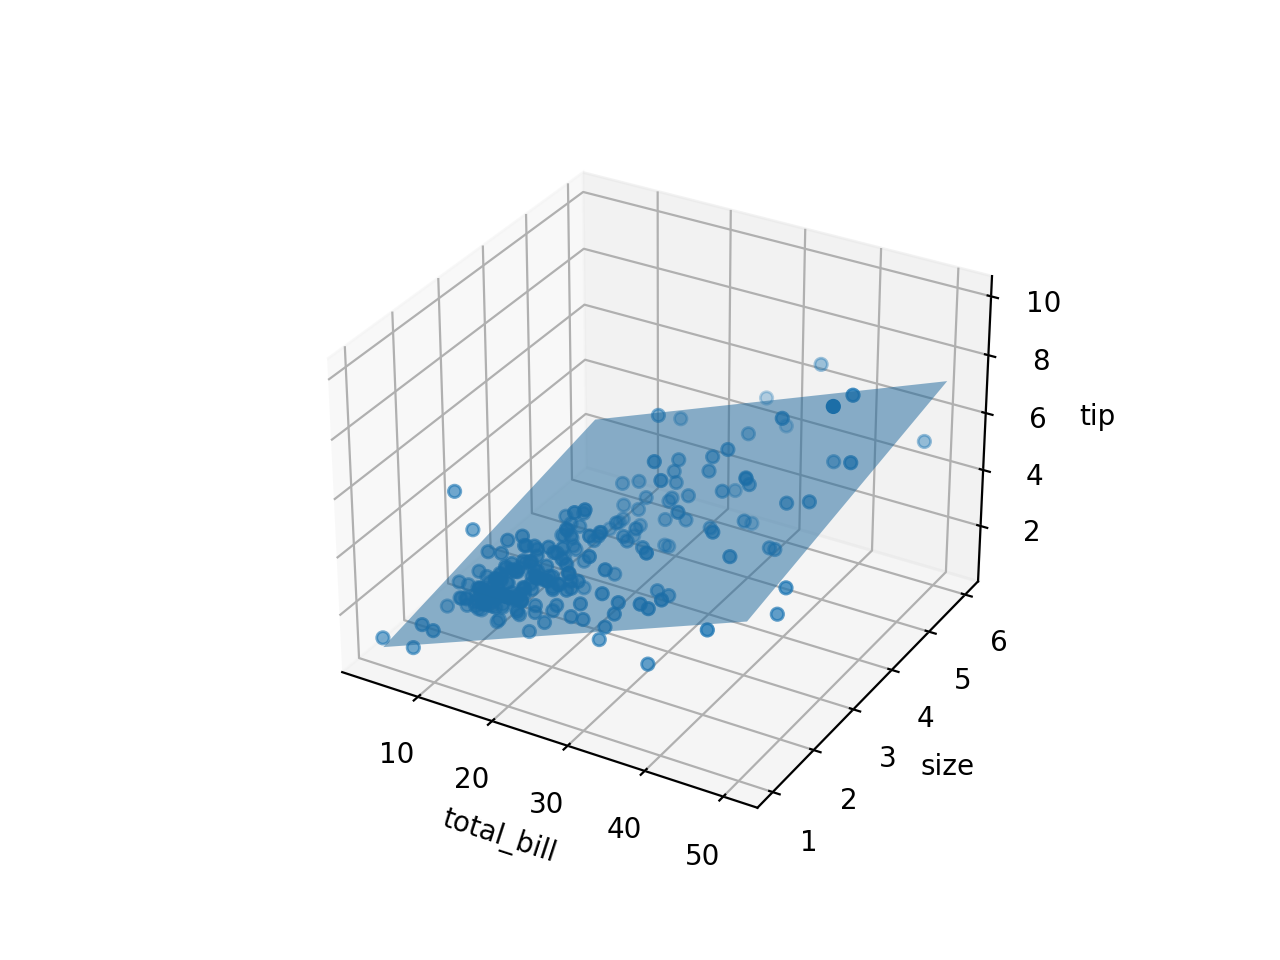

In [6]:
plot_hyperplane();

# How do we find the best weight vector?

Ordinary least squares (OLS) is the most common linear regression technique and the one that was used above by scikit-learn. OLS aims to minimize the residual sum of squares (RSS):

$$RSS = \sum_{i=1}^n \left(h(\mathbf{x}_i) - y_i\right)^2 = \sum_{i=1}^n \left(\mathbf{w}^T\mathbf{x}_i - y_i\right)^2$$

Equivalently, OLS minimizes mean squared error (MSE) loss:
$$L(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n \left(\mathbf{w}^T\mathbf{x}_i - y_i\right)^2$$

$$\mathbf{w}^* = \textrm{argmin}_\mathbf{w} L(\mathbf{w})$$

In [7]:
def L(w):
    return np.mean((df[["total_bill", "size"]] @ w - df["tip"])**2)

<IPython.core.display.Javascript object>


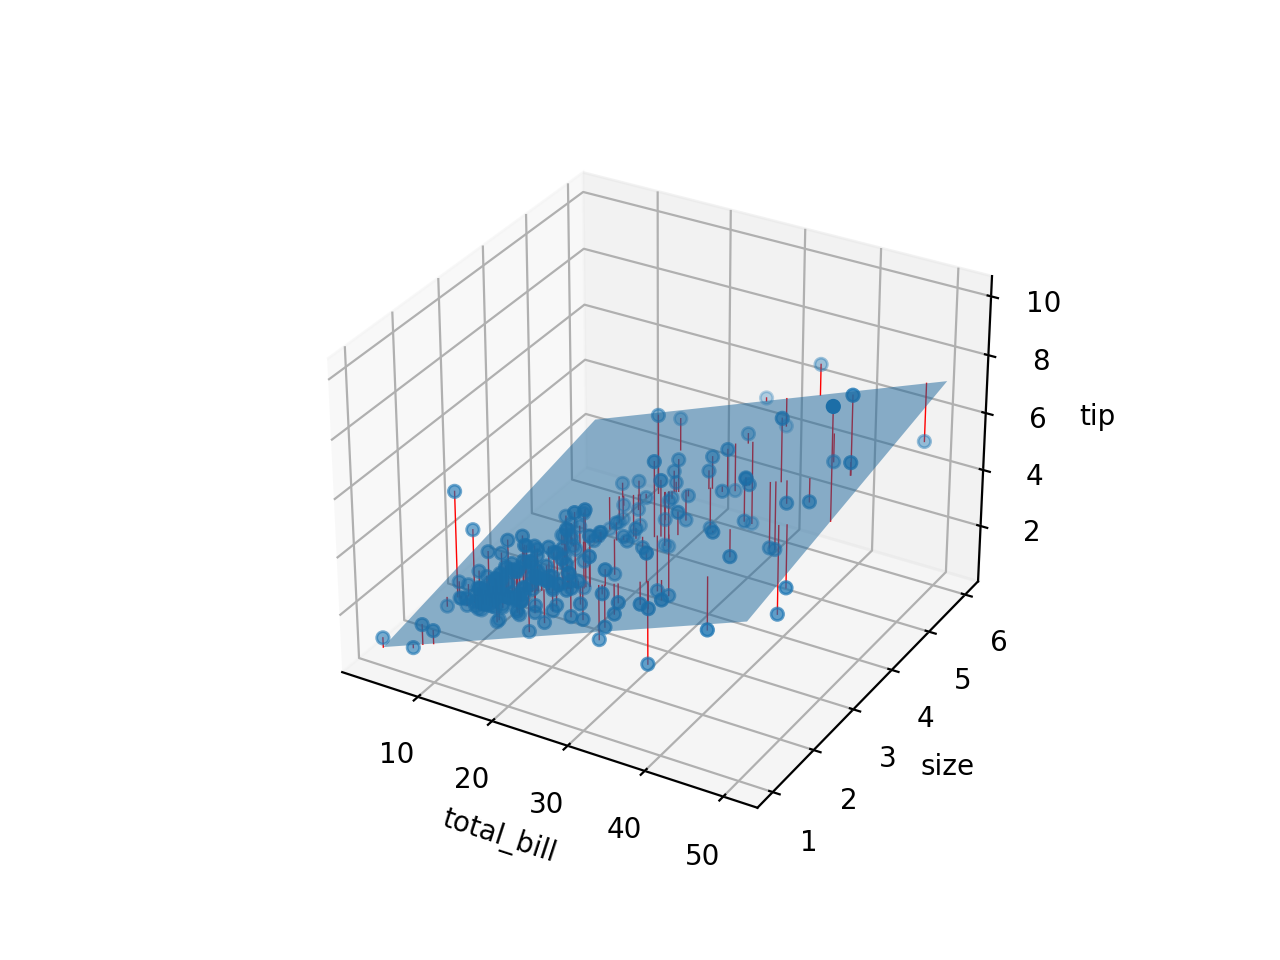

In [8]:
ax = plot_hyperplane()
for x, y, z0, z1 in zip(df["total_bill"], df["size"], df["tip"], df[["total_bill", "size"]] @ w_star):
    ax.plot([x, x], [y, y], [z0, z1], c="r", lw=.5)

In [9]:
def plot_loss_surface():
    wlim = (-.5, .5)
    w0 = w1 = np.linspace(*wlim)
    ww0, ww1 = np.meshgrid(w0, w1, indexing="ij")
    loss_mesh = np.zeros_like(ww0)
    for i in range(len(w0)):
        for j in range(len(w1)):
            w = [w0[i], w1[j]]
            loss_mesh[i, j] = L(w)
    zlim = (0, loss_mesh.max())
    
    fig = plt.figure(constrained_layout=True)
    ax = fig.add_subplot(projection="3d")
    ax.scatter(w_star[0], w_star[1], L(w_star), c="r", marker="x")
    ax.plot_surface(ww0, ww1, loss_mesh, cmap="viridis", alpha=.5)
    ax.set(xlabel="$w_0$", xlim=wlim, ylabel="$w_1$", ylim=wlim, zlabel="$L(\mathbf{w})$", zlim=zlim)
    return ax

<IPython.core.display.Javascript object>


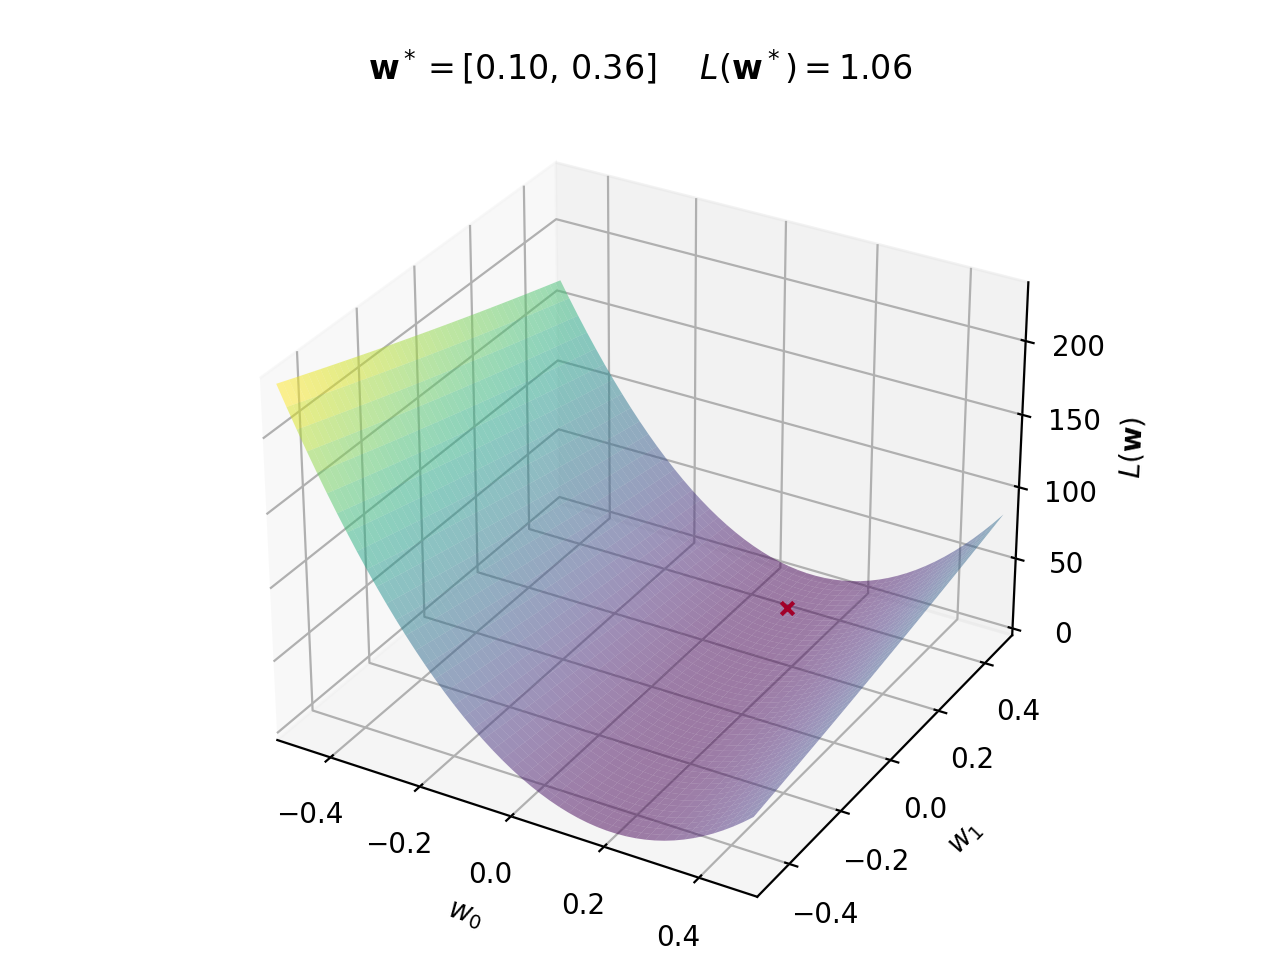

In [10]:
ax = plot_loss_surface()
ax.set(title=f"\n$\mathbf{{w}}^*=$[{w_star[0]:.2f}, {w_star[1]:.2f}]    $L(\mathbf{{w}}^*)=${L(w_star):.2f}");

There are many different optimization algorithms to minimize the RSS. We'll explore one such method, gradient descent.

# Gradient descent

Gradient descent is an iterative optimization algorithm that iteratively takes steps towards a local minimum of a differentiable function using the following update rule:

$$\mathbf{x}_{t+1} = \mathbf{x}_{t} - \alpha\nabla f(\mathbf{x}_t)$$

where $\alpha$ is a constant learning rate of our choosing. Since the gradient is the direction of steepest ascent, each step we move in the opposite direction of the gradient to attempt to descend the function.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*sUj0ZEau1ooTNg6bnYlebg.png" width="50%"/>

We can use gradient descent to find the $\mathbf{w}$ that minimizes $L(\mathbf{w})$:

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha\nabla L(\mathbf{w}_t)$$

Gradient descent is guaranteed to find the global minimum of a convex function as long as the learning rate is not too large. Since our $L(\mathbf{w})$ is convex, we can use gradient descent to find the globally optimal $\mathbf{w}^*$.

Let's calculate the gradient $\nabla_\mathbf{w} L(\mathbf{w})$:

$$\begin{align}
\nabla_\mathbf{w} L(\mathbf{w})
&= \nabla_\mathbf{w} \frac{1}{n}\sum_{i=1}^n \left(\mathbf{w}^T\mathbf{x}_i - y_i\right)^2\\
&= \frac{1}{n}\sum_{i=1}^n\nabla_\mathbf{w} \left(\mathbf{w}^T\mathbf{x}_i - y_i\right)^2\\
&= \frac{2}{n}\sum_{i=1}^n \left(\mathbf{w}^T\mathbf{x}_i - y_i\right) \mathbf{x}_i\\
\end{align}$$

So we can use the following update rule:

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha\frac{1}{n}\sum_{i=1}^n \left(\mathbf{w}^T\mathbf{x}_i - y_i\right) \mathbf{x}_i$$

In [11]:
def gradient(w):
    residual = (df[["total_bill", "size"]] @ w - df["tip"]).values.reshape(-1, 1)
    x = df[["total_bill", "size"]].values
    return np.mean(residual * x, axis=0)

def update(w, alpha):
    return w - alpha * gradient(w)

def gradient_descent(iterations, alpha):
    w = np.zeros(2)
    w0_history, w1_history, l_history = [], [], []
    for _ in range(iterations + 1):
        w0_history.append(w[0])
        w1_history.append(w[1])
        l_history.append(L(w))
        w = update(w, alpha)
    return np.array(w0_history), np.array(w1_history), np.array(l_history)

def plot_gradient_descent(iterations, alpha):
    w0_history, w1_history, l_history = gradient_descent(iterations, alpha)
    ax = plot_loss_surface()
    ax.plot(w0_history, w1_history, l_history, c="k", lw=.5)
    ax.scatter(w0_history[0], w1_history[0], l_history[0], c="k", marker=".")
    title = ""
    title += f"$\mathbf{{w}}_0=$[{w0_history[0]:.2f}, {w1_history[0]:.2f}]    $L(\mathbf{{w}}_0)=${l_history[0]:.2f}"
    i = len(w0_history) - 1
    title += f"\n$\mathbf{{w}}_{{{i}}}=$[{w0_history[i]:.2f}, {w1_history[i]:.2f}]    $L(\mathbf{{w}}_{{{i}}})=${l_history[i]:.2f}"
    title += f"\n$\mathbf{{w}}^*=$[{w_star[0]:.2f}, {w_star[1]:.2f}]    $L(\mathbf{{w}}^*)=${L(w_star):.2f}"
    ax.set(title=title)
    return ax

# Setting the learning rate

## Divergence in $\textbf{w}_0$

<IPython.core.display.Javascript object>


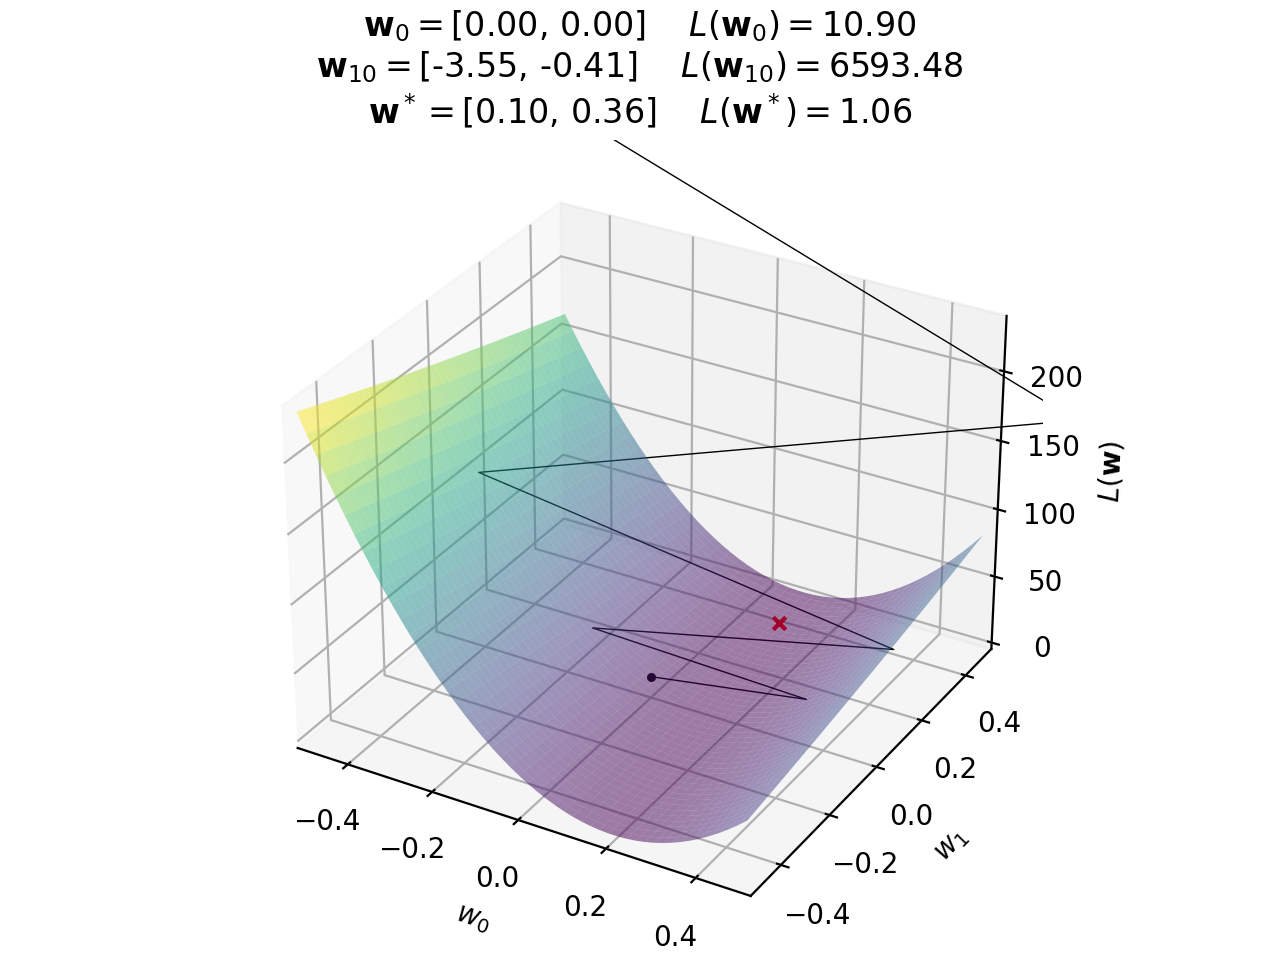

In [12]:
plot_gradient_descent(10, .005);

## No divergence, but oscillation in $\textbf{w}_0$

<IPython.core.display.Javascript object>


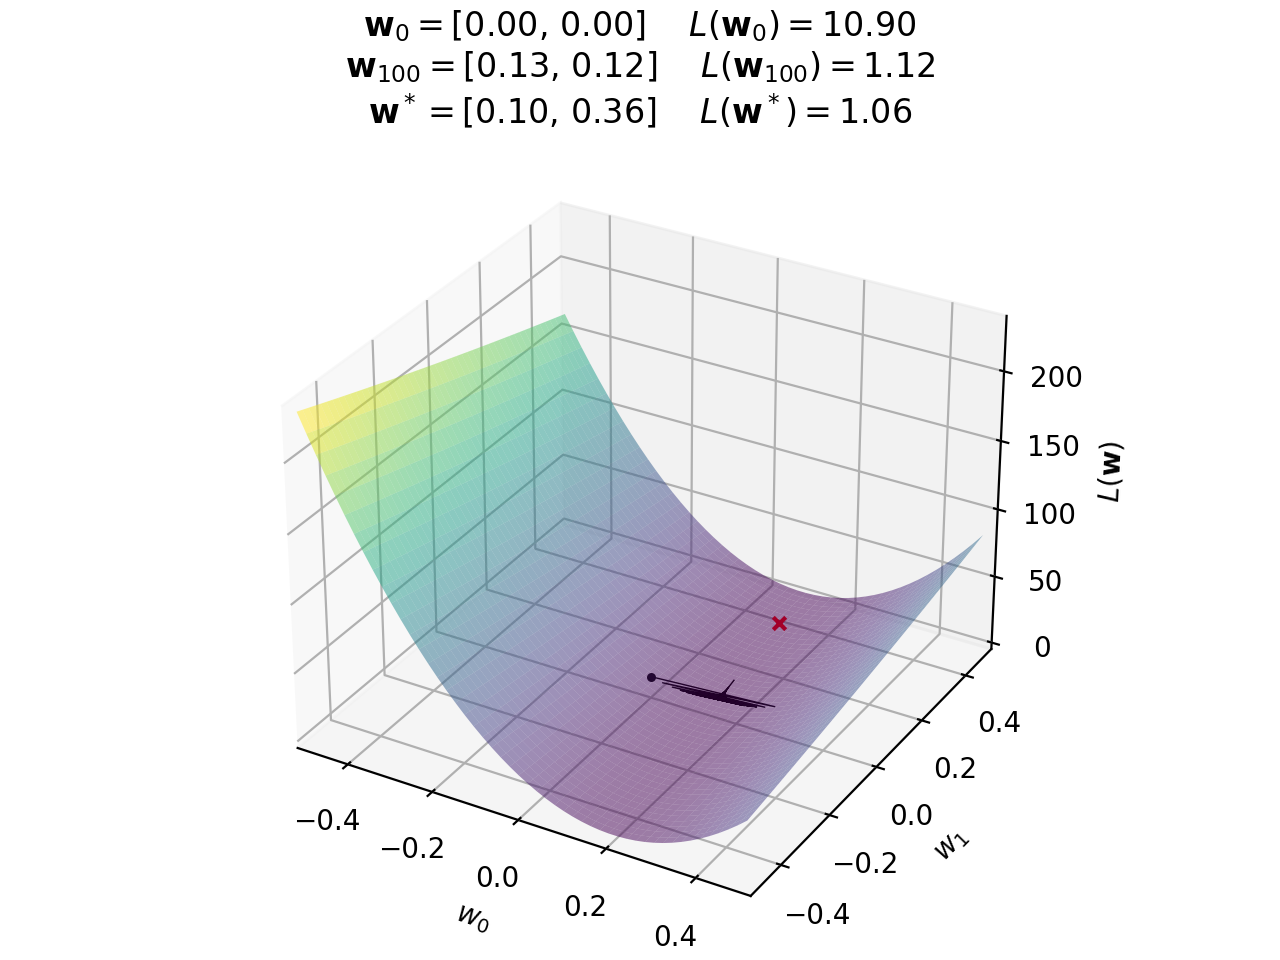

In [13]:
plot_gradient_descent(100, .004);

## No oscillation, but still slow convergence

<IPython.core.display.Javascript object>


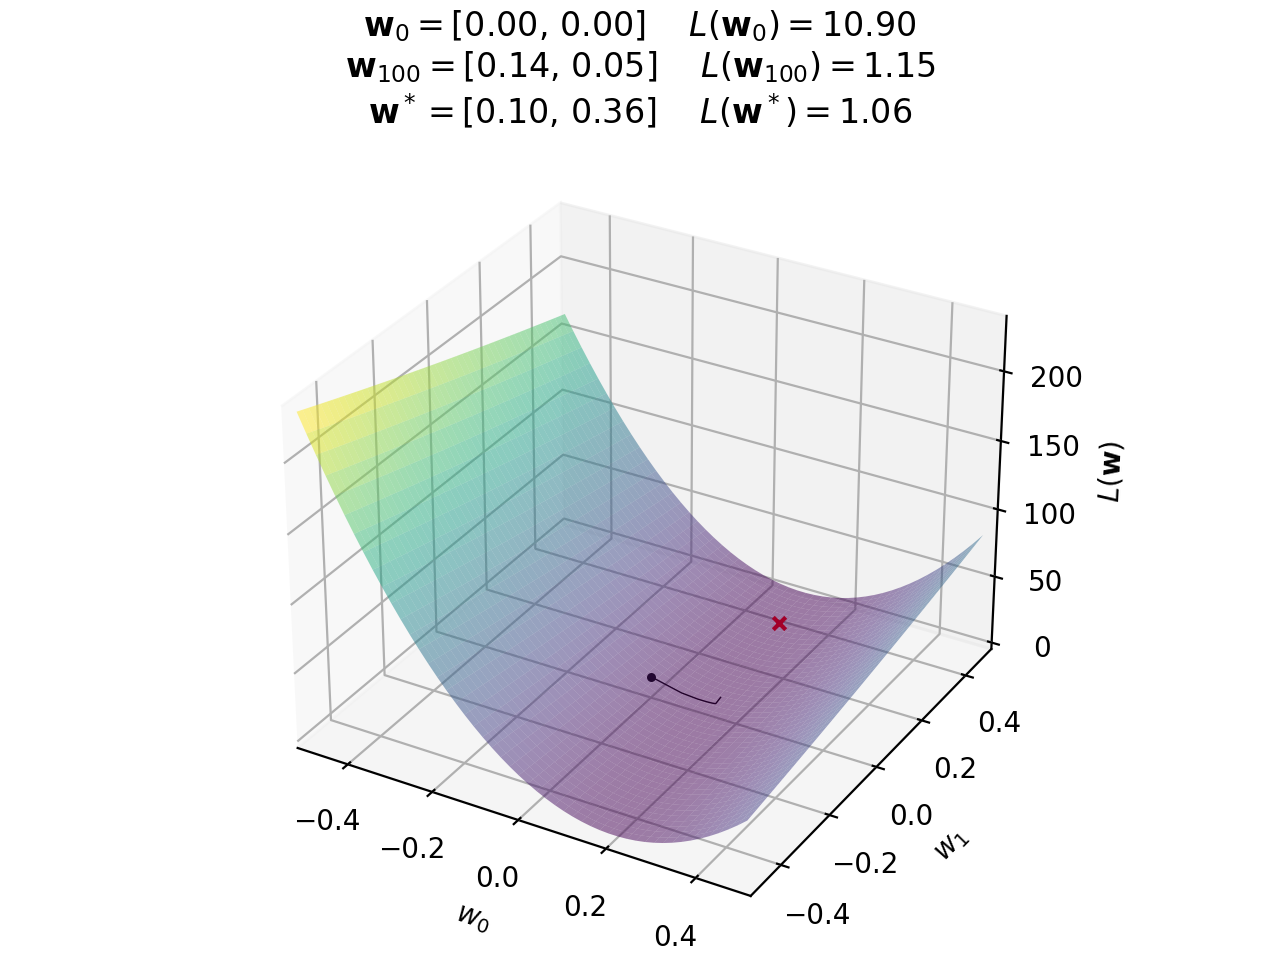

In [14]:
plot_gradient_descent(100, .001);

## Summary

The scale of `total_bill` is much larger than `size`, causing $\frac{\partial L(\mathbf{w})}{\partial w_0}$ to be much larger than $\frac{\partial L(\mathbf{w})}{\partial w_1}$, resulting in the learning rate being too fast for $w_0$ and too slow for $w_1$, leading to either divergence/oscillation in $w_0$ or slow convergence in $w_1$.

# Can feature scaling fix this problem?